In [1]:
import sys
sys.path.append("../")

from yolotrt import YoloTRT

half = True
imgsz = 1280
ahoy_trt = YoloTRT(
    trt_engine_path="weights/ahoy.engine",
    img_size=imgsz,
)

Loading TensorRT inference engine weights/ahoy.engine
 - Input shape: (1, 3, 1280, 1280)
 - Input dtype: float16


In [2]:
import numpy as np
from PIL import Image
image = np.array(Image.open("examples/example_1.jpg"))
ahoy_trt.detect(image, output_mode="tf")

# class -1 is the horizon line where x1, y1, x2, y2 are the coordinates of the horizon end points

{'detection_boxes': array([[[5.35937500e-01, 3.17968750e-01, 5.43750000e-01, 3.30468750e-01],
         [2.57500000e+02, 1.12166667e+02, 2.61500000e+02, 1.13833333e+02],
         [0.00000000e+00, 2.39355169e-01, 1.00000000e+00, 2.86074740e-01],
         [2.22333333e+02, 1.36666667e+02, 2.39666667e+02, 1.49666667e+02]]]),
 'detection_scores': array([[0.62597656, 0.2322998 , 0.81103516, 0.51323099]]),
 'detection_classes': array([[ 2.,  1.,  4., -1.]]),
 'num_detections': 1}

 19.5 ms [avg] - preprocess
  8.0 ms [avg] - inference
  2.8 ms [avg] - postprocess
bboxes=array([[772.5, 336.5, 784.5, 341.5],
       [686. , 407. , 696. , 423. ],
       [667. , 410. , 719. , 449. ]]), scores=array([0.62597656, 0.2322998 , 0.81103516]), classes=array([2., 1., 4.]), hor_points=array([[   0.        ,  306.37461633, 1280.        ,  366.17566762]]), hor_score=array([0.51323099])


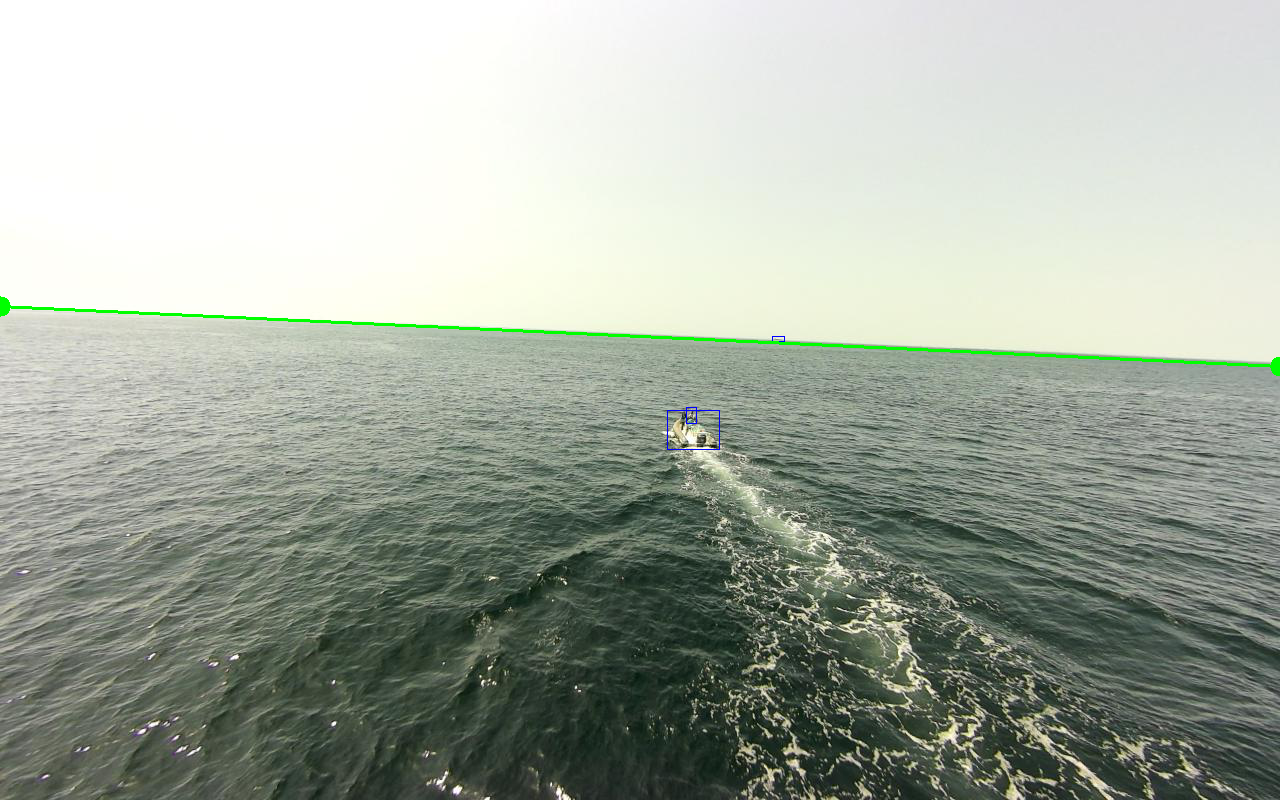

In [3]:
import numpy as np
from PIL import Image

from utils.horizon import draw_horizon, draw_bboxes
from yolotrt.misc import Profile
from yolotrt.preprocessing import letterbox

image = np.array(Image.open("examples/example_1.jpg"))

ahoy_trt(image, conf_thresh=0.147, iou_thresh=0.1)  # warmup
n = 100
for i in range(n):
    preds = ahoy_trt(image, conf_thresh=0.147, iou_thresh=0.1)[0]

# print average times
for name, profile in ahoy_trt.profiles.items():
    print(f"{profile.t / n * 1E3:>5.1f} ms [avg] - {name}")

bboxes = preds[:, :4] # x1, y1, x2, y2
scores = preds[:, 4] # scores (probabilities)
classes = preds[:, 5] # indices of classes
hor_points, hor_score = bboxes[classes == -1], scores[classes == -1]
bboxes, scores, classes = bboxes[classes != -1], scores[classes != -1], classes[classes != -1]
print(f"{bboxes=}, {scores=}, {classes=}, {hor_points=}, {hor_score=}")

I = image
dets = np.hstack((bboxes, scores[:, np.newaxis], classes[:, np.newaxis]))
I = draw_bboxes(I, dets, color=(0, 0, 255), thickness=1)
I = draw_horizon(I, keypoints=hor_points.reshape(-1, 2), color=(0, 255, 0))
I = Image.fromarray(I)
I  # .reduce(2) if I.width >= 1024 else I

In [5]:
ahoy_trt.detect(image, output_mode="tf")

AssertionError: Input image must have 3 dimensions (h, w, c)